In [1]:
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.linear_model import LinearRegression
import os
import pandas as pd

In [2]:
def detect_circle(path: str, max_min_radius: tuple):
    original_pil = Image.open(path)
    gray_pil = original_pil.convert("L")
    gray = np.array(gray_pil)

    gray_blur = cv2.GaussianBlur(gray, (9, 9), 2)

    circles = cv2.HoughCircles(
        gray_blur,
        cv2.HOUGH_GRADIENT,
        dp=1.2,
        minDist=100,
        param1=100,
        param2=30,
        minRadius=max_min_radius[0],
        maxRadius=max_min_radius[1]
    )

    frame = np.array(original_pil)


    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        circles = sorted(circles, key=lambda x: x[2], reverse=True)

        x, y, r = circles[0]
        cv2.circle(frame, (x, y), r, (0, 255, 0), 4)
        n = 18
        r_reduced = max(1, r - n)
        cv2.circle(frame, (x, y), r_reduced, (255, 0, 255), 2)

        mask = np.zeros_like(gray)
        cv2.circle(mask, (x, y), r_reduced, (255, 255, 255), -1)
        masked = cv2.bitwise_and(gray, mask)

    else:
        masked = np.zeros_like(gray)

    return masked


In [3]:
path_list = os.listdir("fotos_experimento2")


In [4]:
def ordenar(item):
    partes = item.split()
    num_principal = int(partes[0])
    num_placa = int(partes[2])
    hora = partes[3].replace('.jpg', '')
    return (num_principal, num_placa, hora)

path_list.sort(key=ordenar)


In [5]:
path_image_list = ['fotos_experimento2/' + i for i in path_list]

In [6]:
df = pd.DataFrame()
datas = []
samples = []

for path in path_image_list:
    for i in range(1,4):
        id = "placa " + str(i)
        if id in path:
            id_name = id
    
    data = path[-12:].split('.')[0].replace("_",":")

    datas.append(data)
    samples.append(id_name)


df['Hora'] = datas
df['Amostra'] = samples
df['Pasta'] = path_image_list

In [7]:



matrix_medias = []

for j in range(1,3):
    filtro = df['Amostra'] == f'placa {j}'
    df_p_uso = df[filtro]

    medias = []
    progresso = []

    for i,pasta in enumerate(df_p_uso['Pasta']):
            
        imagem = detect_circle(pasta,(200,210))
        filter = (imagem > 90) & (imagem < 180)

        media = imagem.reshape(-1).mean()
        media = np.count_nonzero(filter*255)/np.count_nonzero(imagem)

        medias.append(media)
        progresso.append(i)

    medias = np.array(medias)#-medias[0]
    matrix_medias.append(medias)



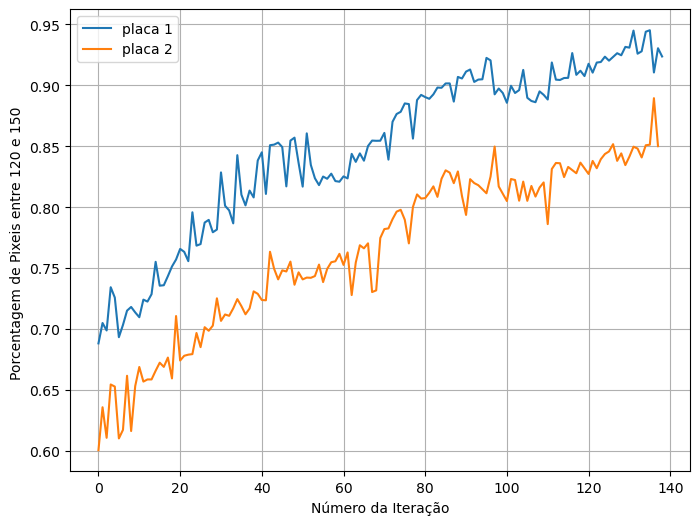

In [8]:
plt.figure(figsize=(8,6))
plt.grid()
for i in range(2):
    plt.plot([j for j in range(len(matrix_medias[i]))],matrix_medias[i], label=f'placa {i+1}')

    plt.legend()
    plt.ylabel("Porcentagem de Pixeis entre 120 e 150 ")

    plt.xlabel("Número da Iteração")


In [9]:
import numpy as np
from scipy.optimize import curve_fit

def verhulst(t, K, A, r):
    return K / (1 + A * np.exp(-r * t))

verhulst_curvas = []

parametros_fit =[]

for i in range(len(matrix_medias)):
    t = np.arange(len(matrix_medias[i]))
    y = np.array(matrix_medias[i])

    p0 = [max(y), 1, 0.1]
    params, _ = curve_fit(verhulst, t, y, p0=p0, maxfev=10000)

    parametros_fit.append(params)
    


In [10]:
K, A, r = parametros_fit[0] 
t = np.arange(138)
Vr1 = K / (1 + A * np.exp(-r * t))


K, A, r = parametros_fit[1] 
t = np.arange(138)
Vr2 = K / (1 + A * np.exp(-r * t))


Text(0.5, 0, 'Tempo(h)')

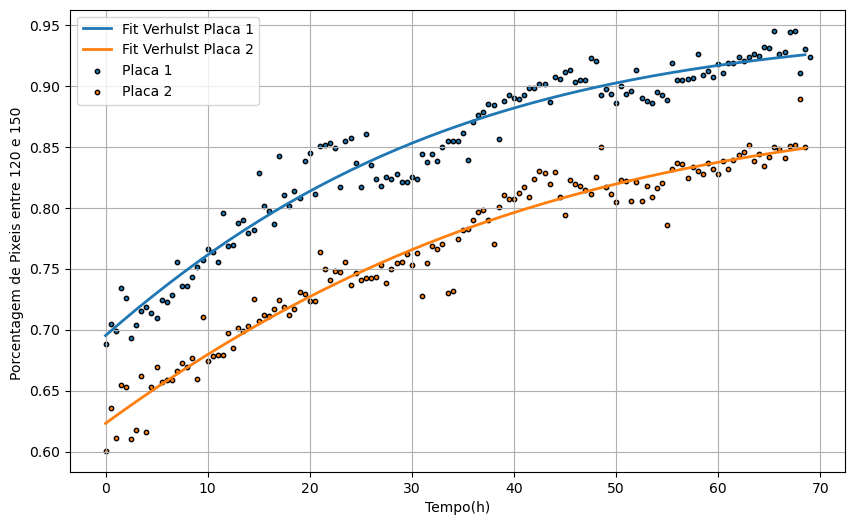

In [11]:
plt.figure(figsize=(10,6))
plt.grid()

for i in range(2):
    tempo = np.arange(len(matrix_medias[i]))/2

    plt.scatter(tempo,matrix_medias[i], label=f'Placa {i+1}',s=10,edgecolors='black')

    
t = np.arange(len(Vr1))/2
plt.plot(t,Vr1, label="Fit Verhulst Placa 1",linewidth=2)
plt.plot(t,Vr2, label="Fit Verhulst Placa 2",linewidth=2)

plt.legend()
plt.ylabel("Porcentagem de Pixeis entre 120 e 150 ")

plt.xlabel("Tempo(h)")

